This work is done by Polina Turishcheva, December 2020

## Dependencies installation

In [2]:
!pip install plotly

You should consider upgrading via the '/Users/polinaturiseva/anaconda3/bin/python -m pip install --upgrade pip' command.


In [50]:
!pip install lightgbm

You should consider upgrading via the '/Users/polinaturiseva/anaconda3/bin/python -m pip install --upgrade pip' command.


In [9]:
!pip install folium

In [2]:
!pip install pandas_profiling

You should consider upgrading via the '/Users/polinaturiseva/anaconda3/bin/python -m pip install --upgrade pip' command.


## Here is a part of data processing and model training
### If you are not interested, you may go to demo1 with comment sentiment prediction and demo 2 - with price prediction. All preprocessed data and trained models are saved and will be uploaded


In [1]:
import pandas as pd
import sklearn
import numpy
from collections import Counter, defaultdict
%pylab inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from nltk.sentiment.vader import SentimentIntensityAnalyzer  
import warnings
import lightgbm as lgb
from sklearn.model_selection import train_test_split

from tqdm import tqdm
warnings.filterwarnings("ignore")

Populating the interactive namespace from numpy and matplotlib


/Users/polinaturiseva/anaconda3/lib/python3.7/site-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


In [2]:
path = 'data/'

In [7]:
calendar_df = pd.read_csv(f'{path}calendar.csv', index_col='listing_id')
reviews_df  = pd.read_csv(f'{path}reviews.csv', index_col='listing_id')
train_df    = pd.read_csv(f'{path}train.csv', index_col='id')
test_df     = pd.read_csv(f'{path}test.csv', index_col='id')

/Users/polinaturiseva/anaconda3/lib/python3.7/site-packages/numpy/lib/arraysetops.py:568: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [8]:
from pandas_profiling import ProfileReport

train_profile = ProfileReport(train_df, title="Train data report")
test_profile = ProfileReport(test_df, title="Test data report")
review_profile = ProfileReport(reviews_df, title="Reviews report")
calendar_profile = ProfileReport(calendar_df, title="Calendar report")

train_profile.to_file('profiles/train_profile.html')
test_profile.to_file('profiles/test_profile.html')
review_profile.to_file('profiles/review_profile.html')
calendar_profile.to_file('profiles/calendar_profile.html')

Summarize dataset:   0%|          | 0/57 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

Summarize dataset:   0%|          | 0/56 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

Summarize dataset:   0%|          | 0/20 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

Summarize dataset:   0%|          | 0/17 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

In [9]:
# free RAM
calendar_df = None
reviews_df  = None
train_df    = None
test_df     = None

## Data cleaning

In [38]:
def change_ammenities(amm):
    return sorted(amm.replace('{', '').replace('}', ',').replace('"', '').lower().split(','))[1:]

In [39]:
calendar = pd.read_csv(f'{path}calendar.csv')
reviews = pd.read_csv(f'{path}reviews.csv')
train = pd.read_csv(f'{path}train.csv')

In [40]:
train['cancellation_policy'] = train.cancellation_policy.astype('category')
train['require_guest_profile_picture'] = train.require_guest_profile_picture.astype('category')
train['require_guest_phone_verification']= train.require_guest_phone_verification.astype('category')
train['is_location_exact'] = train.is_location_exact.astype('category')
train['property_type'] = train.property_type.astype('category')
train['room_type'] = train.room_type.astype('category')
train['bed_type'] = train.bed_type.astype('category')
train['experiences_offered'] = train.experiences_offered.astype('category')
train['id'] = train.id.astype('category')
train['host_id'] = train.host_id.astype('category')
train['host_response_time'] = train.host_response_time.astype('category')
train['host_is_superhost'] = train.host_is_superhost.astype('category')
train['host_has_profile_pic'] = train.host_has_profile_pic.astype('category')
train['host_identity_verified'] = train.host_identity_verified.astype('category')
train['neighbourhood_cleansed'] = train.neighbourhood_cleansed.astype('category')

train['amenities'] = train['amenities'].apply(lambda x: change_ammenities(x))

In [41]:
reviews['listing_id'] = reviews.listing_id.astype('category')
reviews['id'] = reviews.id.astype('category')
reviews['reviewer_id'] = reviews.reviewer_id.astype('category')
reviews['comments'] = reviews['comments'].apply(lambda x: str(x).replace('\r', '').replace('\n', '')) 
reviews.drop(columns=['reviewer_name'], inplace=True)
calendar['listing_id'] = calendar.listing_id.astype('category')
calendar['available'] = calendar.available.astype('category')

In [42]:
train.drop(columns=['bed_type', 'experiences_offered', 'host_response_rate', 'square_feet', 
                    'require_guest_phone_verification', 'require_guest_profile_picture', 
                    'host_has_profile_pic', 'name', 'zipcode'], inplace=True)

## Todo positive/negative classification of reviews
* http://www.nltk.org/howto/sentiment.html



In [105]:
# http://www.nltk.org/howto/sentiment.html
sid = SentimentIntensityAnalyzer()
reviews['pos'] = 0.0
reviews['neg'] = 0.0
reviews['neu'] = 0.0
reviews['compound'] = 0.0
reviews['sentiment'] = 'neu'
for s in tqdm(range(len(reviews['comments']))):
    sentence = reviews['comments'][s]
    ss = sid.polarity_scores(sentence)
    reviews['neg'][s] = ss['neg']
    reviews['pos'][s] = ss['pos']
    reviews['neu'][s] = ss['neu']
    reviews['compound'][s] = ss['compound']
    if ss['neg'] > max(ss['pos'], ss['neu']):
        reviews['sentiment'][s] = 'neg'
    elif ss['pos'] > ss['neu']:
        reviews['sentiment'][s] = 'pos'

100%|██████████| 1137324/1137324 [24:17<00:00, 780.40it/s]


In [ ]:
# reviews.to_csv(f'{path}reviews_with_sentiment.csv')

In [ ]:
# reviews = pd.read_csv(f'{path}reviews_with_sentiment.csv')

## Interactive Model Demo for sentiment analysis

### PLEASE ENTER YOU PHRASE TO TEST FURTHER

In [3]:
PHRASE = 'i love cats' # ENTER YOUR SENTENCE INSTAED OF CATS

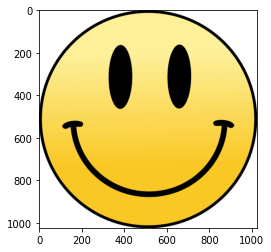

In [6]:
sid = SentimentIntensityAnalyzer()
d = sid.polarity_scores(PHRASE)
neg, pos, neutral = d['neg'], d['pos'], d['neu']
img_path = ''

if neg > max(pos, neutral):
    img_path = 'pictures/negative.png'
elif pos > neutral:
    img_path = 'pictures/positive.png'
else:
    img_path = 'pictures/neutral.png'
    
img = mpimg.imread(img_path)
imgplot = plt.imshow(img)
plt.show()

## Augment Columns

In [ ]:
train_ids = set(list(train['id']))
calendar_ids = set(list(calendar['listing_id']))
reviews_ids = set(list(reviews['listing_id']))

train_calendar = train_ids.intersection(calendar_ids)
train_reviews = train_ids.intersection(reviews_ids)

In [ ]:
perc = defaultdict(int)
fin_prec = defaultdict(int)

for i in range(len(calendar)):
    if calendar['available'][i] == 't':
        perc[f'{calendar["listing_id"][i]}_free'] +=1
    else:
        perc[f'{calendar["listing_id"][i]}_nonfree'] +=1

for i in list(set(list(calendar['listing_id']))):
    fin_prec[i] = perc[f'{i}_free'] / (perc[f'{i}_free'] + perc[f'{i}_nonfree'])
                                                                
calendar['perc_free'] = calendar['listing_id'].apply(lambda x: fin_prec[x])

In [ ]:
fin_sentiment = {}
for i in list(train_reviews):
    sum_over_rows = reviews[reviews['listing_id']==i].sum(axis=0)
    neutral = sum_over_rows['neu'] * 0.6
    if sum_over_rows['neg'] > max(sum_over_rows['pos'], neutral):
        fin_sentiment[i] = 'neg'
    elif sum_over_rows['pos'] > neutral:
        fin_sentiment[i] = 'pos'
    else:
        fin_sentiment[i] = 'neu'

In [ ]:
train['perc_free'] = None
train['perc_free'] = train['id'].apply(lambda x : fin_prec[x] if x in train_calendar else None)
train['review_sentiment'] = None
train['review_sentiment'] = train['id'].apply(lambda x : fin_sentiment[x] if x in train_reviews else None)
train['review_sentiment'] = train.review_sentiment.astype('category')
host_houses = Counter(list(train['host_id']))
train['host_houses'] = train['host_id'].apply(lambda x: host_houses[x])

In [ ]:
from sklearn.preprocessing import MultiLabelBinarizer

mlb = MultiLabelBinarizer(sparse_output=True)

train = train.join(
            pd.DataFrame.sparse.from_spmatrix(
                mlb.fit_transform(train.pop('amenities')),
                index=train.index,
                columns=mlb.classes_))

## Select only some columns based on properties frequencies and profile analytics

In [ ]:
columns_to_save = set(['id', 'latitude', 'longitude', 'bathrooms', 'bedrooms', 'host_id',
       'host_is_superhost', 'host_since', 'neighbourhood_cleansed',
       'room_type', 'security_deposit', 'is_location_exact', 'beds',
       'cleaning_fee', 'guests_included', 'extra_people', 'minimum_nights',
       'cancellation_policy', 'property_type', 'host_houses', 'perc_free',
       'review_sentiment', 'accommodates', 'price', 'buzzer/wireless intercom',
       'shampoo', 'smoking allowed', 'elevator', 'single level home',
       'refrigerator', 'indoor fireplace', 'hot tub', 'garden or backyard',
       'family/kid friendly', 'private entrance', 'wide hallway clearance',
       'bathtub', 'patio or balcony', 'breakfast', 'hair dryer', 'other',
       'dishwasher', 'private living room', 'carbon monoxide detector',
       'stove', 'first aid kit', 'host greets you', 'long term stays allowed',
       'washer', 'ethernet connection', 'paid parking off premises', 'dryer',
       'well-lit path to entrance', 'internet', 'fire extinguisher',
       'flat path to front door', 'dishes and silverware', 'air conditioning',
       'smoke detector', 'free street parking', 'iron',
       'children’s books and toys', 'step-free access', 'pets allowed',
       'cable tv', 'free parking on premises', 'high chair',
       '24-hour check-in', 'wide doorway', 'pack ’n play/travel crib',
       'paid parking on premises', 'tv', 'safety card', 'cooking basics',
       'hot water', 'self check-in', 'bed linens', 'crib',
       'laptop friendly workspace', 'coffee maker', 'lock on bedroom door',
       'lockbox', 'extra pillows and blankets', 'gym',
       'luggage dropoff allowed', 'hangers', 'microwave'])

In [ ]:
cleared_features = train[columns_to_save]

### Reducing the amount of classes in categorical columns

In [ ]:
property_type = dict(Counter(cleared_features['property_type']))

In [3]:
def correct_property_type(x):
    if property_type[x] < 400:
        return 'else'
    else:
        return x.lower()


def update_host_since(x):
    if not pd.isna(x):
        try:
            year = str(x).split('-')[0]
            month = str(x).split('-')[1]
            return (2019 - int(year)) * 12 - int(month)
        except:
            return float('nan')
    else:
        return x
    
    
def update_guests_included(x):
    if x >= 7:
        return int(7)
    else:
        return int(x)  
    
    
def update_beds(x):
    if not pd.isna(x):
        try:
            if int(x) >= 7:
                return int(7)
            else:
                return int(x)
        except:
            return float('nan')
    else:
        return x
    
    
def update_min_nights(x):
    if not pd.isna(x):
        try:
            if int(x) <= 5:
                return float(x)
            elif x<=7:
                return float(6.5)
            else:
                return float(8.0)
        except:
            return float('nan')
    else:
        return x 
    
    
def update_bathrooms(x):
    if not pd.isna(x):
        try:
            if float(x) <= 1:
                return int(0)
            elif float(x) <= 2:
                return int(1)
            elif float(x) <= 3:
                return int(2)
            elif float(x) <= 4:
                return int(3)
            else:
                return int(4)
        except:
            return float('nan')
    else:
        return x
    
    
def update_bedrooms(x):
    if not pd.isna(x):
        try:
            if int(x) >= 5:
                return int(7)
            else:
                return int(x)
        except:
            return float('nan')
    else:
        return x
    
    
def to_int(x):
    if x == 'f':
        return 0
    else:
        return 1

In [ ]:
cleared_features['host_since'] = cleared_features['host_since'].apply(lambda x: update_host_since(str(x)))
cleared_features['minimum_nights'] = cleared_features['minimum_nights'].apply(lambda x: update_min_nights(x))
cleared_features['bathrooms'] = cleared_features['bathrooms'].apply(lambda x: update_bathrooms(x))
cleared_features['beds'] = cleared_features['beds'].apply(lambda x: update_beds(x))
cleared_features['bedrooms'] = cleared_features['bedrooms'].apply(lambda x: update_bedrooms(x))
cleared_features['guests_included'] = cleared_features['guests_included'].apply(lambda x: update_guests_included(int(x)))
cleared_features['is_location_exact'] = cleared_features['is_location_exact'].apply(lambda x: to_int(str(x)))
cleared_features['property_type'] = cleared_features['property_type'].apply(lambda x: correct_property_type(str(x)))

In [ ]:
# one-hot encoding for categorical values
cleared_features = pd.get_dummies(cleared_features, prefix=['room_type'], columns=['room_type'])
cleared_features = pd.get_dummies(cleared_features, prefix=['neighbourhood_cleansed'], 
                                  columns=['neighbourhood_cleansed'])
cleared_features = pd.get_dummies(cleared_features, prefix=['review_sentiment'], 
                                  columns=['review_sentiment'])
cleared_features = pd.get_dummies(cleared_features, prefix=['cancellation_policy'], 
                                  columns=['cancellation_policy'])
cleared_features = pd.get_dummies(cleared_features, prefix=['property_type'], 
                                  columns=['property_type'])
cleared_features['cancellation_policy_strict'] = cleared_features['cancellation_policy_strict'] + \
    cleared_features['cancellation_policy_strict_14_with_grace_period'] + \
    cleared_features['cancellation_policy_super_strict_30'] + \
    cleared_features['cancellation_policy_super_strict_60']
cleared_features.drop(columns=['cancellation_policy_strict_14_with_grace_period', 
                               'cancellation_policy_super_strict_30', 
                               'cancellation_policy_super_strict_60'], inplace=True)

In [ ]:
# indicating nans
cleared_features['bathrooms_nan'] = cleared_features.isna()['bathrooms']
cleared_features['cleaning_fee_nan'] = cleared_features.isna()['cleaning_fee']
cleared_features['bedrooms_nan'] = cleared_features.isna()['bedrooms']
cleared_features['host_since_nan'] = cleared_features.isna()['host_since']
cleared_features['security_deposit_nan'] = cleared_features.isna()['security_deposit']
cleared_features['beds_nan'] = cleared_features.isna()['beds']
cleared_features['host_is_superhost_nan'] = cleared_features.isna()['host_is_superhost']

In [ ]:
#filling nans
cleared_features.fillna(cleared_features.median(), inplace=True)

In [ ]:
cleared_features.to_csv(f'{path}cleared_test.csv')

In [127]:
# cleared_features.to_csv(f'{path}cleared_train.csv')

## Create and train a model

In [85]:
cleared_features = pd.read_csv(f'{path}cleared_train.csv')
cleared_features.drop(columns=['Unnamed: 0'], inplace=True)

In [86]:
cleared_features['host_is_superhost'] = cleared_features['host_is_superhost'].apply(lambda x: to_int(str(x)))

In [87]:
y = cleared_features['price']
xs = cleared_features.copy()
xs.drop(columns=['price', 'id'], inplace = True)
X_train, X_test, y_train, y_test = train_test_split(xs, y, test_size=0.2, random_state=42)

lgb_train = lgb.Dataset(X_train, y_train)
lgb_valid = lgb.Dataset(X_test, y_test)

In [88]:
params = {
    'nthread': 10,
    'task': 'train',
    'objective': 'regression_l1',
    'metric': 'mape', # this is abs(a-e)/max(1,a)
    'learning_rate': 0.05,
    'tree_learner': 'voting',
    'boosting_type': 'dart',
    'verbose': -1
}

In [89]:
gbm = lgb.train(params, lgb_train, 1000, 
        valid_sets=[lgb_train, lgb_valid],
        early_stopping_rounds=100, verbose_eval=100)

[100]	training's mape: 0.334208	valid_1's mape: 0.302503
[200]	training's mape: 0.311367	valid_1's mape: 0.280369
[300]	training's mape: 0.303996	valid_1's mape: 0.274941
[400]	training's mape: 0.302307	valid_1's mape: 0.274854
[500]	training's mape: 0.296075	valid_1's mape: 0.271992
[600]	training's mape: 0.291643	valid_1's mape: 0.269177
[700]	training's mape: 0.290578	valid_1's mape: 0.269465
[800]	training's mape: 0.288536	valid_1's mape: 0.268059
[900]	training's mape: 0.287133	valid_1's mape: 0.268058
[1000]	training's mape: 0.286189	valid_1's mape: 0.268022


In [90]:
gbm.save_model('mode.txt', num_iteration=gbm.best_iteration)

In [ ]:
# the following line to upload the pretrained model
# bst = lgb.Booster(model_file='mode.txt')

## Data visualization

In [26]:
import folium
from folium.plugins import FastMarkerCluster, MarkerCluster
from folium.plugins import BeautifyIcon

### Interactive map with our training apparetements placements on map

In [27]:
xs = pd.read_csv(f'{path}cleared_train.csv')

In [36]:
lats = xs['latitude'].tolist()
lons = xs['longitude'].tolist()
locations = list(zip(lats, lons))


map1 = folium.Map(location=[51.5074, 0.1277], zoom_start=9.5)
FastMarkerCluster(data=locations).add_to(map1)


In [ ]:
map1

## Placements of our test set elements (Test elements are stars)
### We draw randomly just several test rows due to RAM limits

In [32]:
test = pd.read_csv(f'{path}cleared_test.csv')

In [35]:
# star marker
def create_star():
    icon_star = BeautifyIcon(
    icon='star',
    inner_icon_style='color:blue;font-size:10px;',
    background_color='transparent',
    border_color='transparent')
    return icon_star

lats_test = test['latitude'].tolist()
lons_test = test['longitude'].tolist()
locations_test = list(zip(lats_test, lons_test))
i = 0


for x, y in locations_test:
    i += 1
    folium.Marker([x, y], tooltip='star', icon=create_star()).add_to(map1)
    if i == 500:
        break

In [ ]:
map1

## Predict prices 

In [11]:
prices_train = xs['price'].tolist()

In [12]:
test = pd.read_csv(f'{path}cleared_test.csv')
test['property_type_condominium'] = 0
test['property_type_loft'] = 0
test['property_type_serviced apartment'] = 0
test.drop(columns=['Unnamed: 0', 'id'], inplace = True)
test['host_is_superhost'] = test['host_is_superhost'].apply(lambda x: to_int(str(x)))

In [13]:
bst = lgb.Booster(model_file='mode.txt')
prices_pred = list(bst.predict(test))
prices_total = prices_train + prices_pred

In [14]:
test['price'] = prices_pred 
xs.drop(columns=['Unnamed: 0', 'id'], inplace=True)

In [15]:
test['source_type'] = 'predicted'
xs['source_type']  = 'train'

In [16]:
max_pr = round(max(prices_total))
min_pr = round(min(prices_total))

In [17]:
together = pd.concat([test, xs])

## Interactive part - define your own row for test (already preprocessed for simplicity) and draw a new dot

### It will show 50 closest points to it and its prices (for dots from train set there will be preedicted prices)

In [18]:
# change values to redraw in the prev element - this dict is to help in column navigation
my_test_row = {'id': 594569,
 'host_id': 2701693,
 'host_since': 78.0,
 'host_is_superhost': 0,
 'latitude': 51.57959714916211,
 'longitude': 0.16809507714056368,
 'is_location_exact': 1,
 'accommodates': 1,
 'bathrooms': 0.0,
 'bedrooms': 1.0,
 'beds': 1.0,
 'security_deposit': 0.0,
 'cleaning_fee': 0.0,
 'guests_included': 1,
 'extra_people': 25.0,
 'minimum_nights': 2.0,
 'bathrooms_nan': False,
 'cleaning_fee_nan': False,
 'bedrooms_nan': False,
 'host_since_nan': False,
 'security_deposit_nan': False,
 'beds_nan': False,
 'host_is_superhost_nan': False,
 'property_type_apartment': 0,
 'property_type_bed and breakfast': 0,
 'property_type_condominium': 0,
 'property_type_else': 0,
 'property_type_house': 1,
 'property_type_loft': 0,
 'property_type_serviced apartment': 0,
 'property_type_townhouse': 0,
 'room_type_Entire home/apt': 0,
 'room_type_Private room': 1,
 'room_type_Shared room': 0,
 'neighbourhood_cleansed_Barking and Dagenham': 0,
 'neighbourhood_cleansed_Barnet': 0,
 'neighbourhood_cleansed_Bexley': 0,
 'neighbourhood_cleansed_Brent': 0,
 'neighbourhood_cleansed_Bromley': 0,
 'neighbourhood_cleansed_Camden': 0,
 'neighbourhood_cleansed_City of London': 0,
 'neighbourhood_cleansed_Croydon': 0,
 'neighbourhood_cleansed_Ealing': 0,
 'neighbourhood_cleansed_Enfield': 0,
 'neighbourhood_cleansed_Greenwich': 0,
 'neighbourhood_cleansed_Hackney': 0,
 'neighbourhood_cleansed_Hammersmith and Fulham': 0,
 'neighbourhood_cleansed_Haringey': 0,
 'neighbourhood_cleansed_Harrow': 0,
 'neighbourhood_cleansed_Havering': 1,
 'neighbourhood_cleansed_Hillingdon': 0,
 'neighbourhood_cleansed_Hounslow': 0,
 'neighbourhood_cleansed_Islington': 0,
 'neighbourhood_cleansed_Kensington and Chelsea': 0,
 'neighbourhood_cleansed_Kingston upon Thames': 0,
 'neighbourhood_cleansed_Lambeth': 0,
 'neighbourhood_cleansed_Lewisham': 0,
 'neighbourhood_cleansed_Merton': 0,
 'neighbourhood_cleansed_Newham': 0,
 'neighbourhood_cleansed_Redbridge': 0,
 'neighbourhood_cleansed_Richmond upon Thames': 0,
 'neighbourhood_cleansed_Southwark': 0,
 'neighbourhood_cleansed_Sutton': 0,
 'neighbourhood_cleansed_Tower Hamlets': 0,
 'neighbourhood_cleansed_Waltham Forest': 0,
 'neighbourhood_cleansed_Wandsworth': 0,
 'neighbourhood_cleansed_Westminster': 0,
 'cancellation_policy_flexible': 0,
 'cancellation_policy_moderate': 0,
 'cancellation_policy_strict': 1,
 '24-hour check-in': 0,
 'air conditioning': 0,
 'bathtub': 0,
 'bed linens': 0,
 'breakfast': 0,
 'buzzer/wireless intercom': 0,
 'cable tv': 0,
 'carbon monoxide detector': 0,
 'children’s books and toys': 0,
 'coffee maker': 0,
 'cooking basics': 0,
 'crib': 0,
 'dishes and silverware': 0,
 'dishwasher': 0,
 'dryer': 0,
 'elevator': 0,
 'ethernet connection': 0,
 'extra pillows and blankets': 0,
 'family/kid friendly': 0,
 'fire extinguisher': 0,
 'first aid kit': 0,
 'flat path to front door': 0,
 'free parking on premises': 0,
 'free street parking': 0,
 'garden or backyard': 0,
 'gym': 0,
 'hair dryer': 1,
 'hangers': 0,
 'high chair': 0,
 'host greets you': 1,
 'hot tub': 0,
 'hot water': 1,
 'indoor fireplace': 1,
 'internet': 1,
 'iron': 0,
 'laptop friendly workspace': 0,
 'lock on bedroom door': 0,
 'lockbox': 0,
 'long term stays allowed': 0,
 'luggage dropoff allowed': 0,
 'microwave': 0,
 'other': 0,
 'pack ’n play/travel crib': 0,
 'paid parking off premises': 0,
 'paid parking on premises': 1,
 'patio or balcony': 0,
 'pets allowed': 0,
 'private entrance': 0,
 'private living room': 0,
 'refrigerator': 0,
 'safety card': 0,
 'self check-in': 0,
 'shampoo': 1,
 'single level home': 0,
 'smoke detector': 1,
 'smoking allowed': 0,
 'step-free access': 0,
 'stove': 0,
 'tv': 0,
 'washer': 1,
 'well-lit path to entrance': 0,
 'wide doorway': 0,
 'wide hallway clearance': 0,
 'perc_free': 0.7835616438356164,
 'host_houses': 1,
 'review_sentiment_neg': 0,
 'review_sentiment_neu': 1,
 'review_sentiment_pos': 0}

In [19]:
def compute_distance(stations_lat, stations_lon, point_lat, point_lon):
    R = 6373.0

    lat1, lon1 = np.radians([stations_lat, stations_lon])
    lat2, lon2 = np.radians([point_lat, point_lon])
    a = np.sin((lat2-lat1)/2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin((lon2-lon1)/2.0)**2

    distances = R * 2 * np.arcsin(np.sqrt(a))
    return np.min(distances)

In [20]:
together['distances'] = together.apply(lambda sample: compute_distance(
    my_test_row['latitude'], my_test_row['longitude'], sample.latitude, sample.longitude), axis=1) 

In [21]:
my_test_row = pd.DataFrame.from_dict(my_test_row, orient='index').T
my_test_row.drop(columns=['id'], inplace=True)

In [22]:
for i in test.columns:
    if i != 'price' and i != 'source_type': 
        my_test_row[i] = my_test_row[i].astype(test['elevator'].dtype)

In [23]:
my_price = bst.predict( my_test_row)

In [38]:
neighboors = 150
selected = together.nsmallest(neighboors, 'distances')[['latitude', 'longitude', 'source_type', 'price']]

# star marker
def create_star(sourse):
    if sourse == 'predicted':
        icon = BeautifyIcon(
        icon='star',
        inner_icon_style='color:blue;font-size:10px;',
        background_color='transparent',
        border_color='transparent')
        
    else:
        icon = BeautifyIcon(
        icon_shape='rectangle-dot', 
        border_color='green', 
        border_width=5)
        
    return icon

map2 = folium.Map(location=[my_test_row['latitude'], my_test_row['longitude']], zoom_start=20)

icon_circle = BeautifyIcon(
    icon_shape='circle-dot', 
    border_color='red', 
    border_width=10,
)


folium.Marker([my_test_row['latitude'], my_test_row['longitude']], 
              tooltip=my_price, icon=icon_circle).add_to(map2)
for _, row in selected.iterrows():  
    folium.Marker([row['latitude'], row['longitude']], 
                  tooltip=str(row['price']), icon=create_star(row['source_type'])).add_to(map2)
    


In [ ]:
map2